<a href="https://colab.research.google.com/github/aaronkor/dlai/blob/master/ofolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installs
# ---------------------------
!pip install quandl

# Imports
# ---------------------------
import quandl
import pandas as pd
import numpy as np
import time
from scipy.optimize import minimize
import matplotlib.pyplot as plt

quandl.ApiConfig.api_key = 'yNJSYyossf9pcx-SEepW'

In [0]:
# Optimization Inputs
# ---------------------------
# Portfolio Assets List
tickers = ['CNP', 'F', 'WMT', 'C', 'A', 'V', 'AAL', 'HD', 'MSI', 'GM', 'GS', 'GOOG', 'QCOM', 'CSCO', 'MGAWY', 'PSA', 'LIN', 'KOD']
# Optimizaed for period Start_Date / End_Date
start_date = '2017-4-1'
end_date = '2018-3-31'

In [59]:
# Get Data
# ---------------------------
# If is_online = Ture, retriving from Quandl, else retriving from
# retrieved_date.csv file
is_online = True

if is_online:
    data_columns = ['date', 'ticker', 'adj_close']
    retrieved_date = quandl.get_table('WIKI/PRICES',
                                      ticker=tickers,
                                      qopts={'columns': data_columns},
                                      date={'gte': start_date, 'lte': end_date},
                                      paginate=True
                                      )

    retrieved_date.to_csv('retrieved_date.csv', encoding='utf-8', index=False)
else:
    retrieved_date = pd.read_csv('retrieved_date.csv')
    
# Retrieved Data Manipulation for analysis
clean = retrieved_date.set_index('date')
table = clean.pivot(columns='ticker')

# Data Perperation
returns_daily = table.pct_change()[table.shift(1).notnull()].dropna()
tickers_retrived = returns_daily.columns.droplevel().values
print("Retrived adj_close date for: ", tickers_retrived)

# Importent Variables
sample_size = len(returns_daily)
num_assets = len(tickers_retrived)
print("Total number of assets: ", num_assets,". The sample size is: ",
      sample_size, ". Total Date: ", num_assets*sample_size)
print("======================================")



Retrived adj_close date for:  ['A' 'AAL' 'C' 'CNP' 'CSCO' 'F' 'GM' 'GOOG' 'GS' 'HD' 'MSI' 'PSA' 'QCOM'
 'V' 'WMT']
Total number of assets:  15 . The sample size is:  245 . Total Date:  3675


In [0]:
# Assets Statistics
# ---------------------------

# returns_daily_avg = returns_daily.mean()
returns_daily_avg = np.product(returns_daily + 1) - 1
returns_daily_stdev = np.std(returns_daily, ddof=1) * np.sqrt(sample_size)
cov_daily = np.cov(returns_daily, rowvar=False, ddof=0)

# print(returns_daily_avg)
# print(returns_daily_stdev)
# print(cov_daily)

In [0]:
# Portfolio
# ---------------------------

def get_portfolio(returns, weights):
  weights_arr = np.array([weights])  
  return np.dot(returns,weights_arr.T)

def get_portfolio_return(weights, returns):
  port = get_portfolio(returns, weights)
  return np.product(1 + port) - 1

def get_portfolio_risk(weights, returns):
  weights_arr = np.array([weights])
  w_mat = np.dot(weights_arr.T, weights_arr)
  w_cov_mat = np.sum(w_mat*cov_daily)*(sample_size/(sample_size-1))
  return np.sqrt(w_cov_mat)*np.sqrt(sample_size)

def sharp_r(weights, returns):
  port_return = get_portfolio_return(weights, returns)
  port_risk = get_portfolio_risk(weights, returns)
  return port_return/port_risk

def opt_sharp_r(weights, returns):
  port_return = get_portfolio_return(weights, returns)
  port_risk = get_portfolio_risk(weights, returns)
  return -port_return/port_risk

In [62]:
# Market
eq_weights = np.full(num_assets, 1/num_assets)
market_returns = get_portfolio(returns_daily, eq_weights)
market_return = get_portfolio_return(eq_weights, returns_daily)
market_risk = get_portfolio_risk(eq_weights, returns_daily)
market_sharp = sharp_r(eq_weights,returns_daily)

print("Market Return: ",market_return,"| Market Risk: ", market_risk,
      "| Sharp Ratio: ", market_sharp)


Market Return:  0.15713751862312986 | Market Risk:  0.12300560500618388 | Sharp Ratio:  1.2774825880107663


In [0]:
# Optimization - Minimum Risk
# ---------------------------
w0 = eq_weights
asset_weight_limit = 0.1667
asset_short_limit = 0
bounds = ((asset_short_limit, asset_weight_limit),) * num_assets

minimum_risk = minimize(get_portfolio_risk, w0, method='SLSQP',
                        args=(returns_daily),
                        constraints=({'type': 'eq', 'fun': lambda weights: 1.0 - np.sum(weights)}),
                        bounds=bounds)
minimum_risk_return = get_portfolio_return(minimum_risk.x, returns_daily)
minimun_risk_risk = get_portfolio_risk(minimum_risk.x, returns_daily)

In [64]:
# Optimization - Maximum Sharpe
# ---------------------------

maximum_sharpe = minimize(opt_sharp_r, w0, method='SLSQP',
                        args=(returns_daily),
                        constraints=({'type': 'eq', 'fun': lambda weights: 1.0 - np.sum(weights)}),
                        bounds=bounds)
maximum_sharpe_return = get_portfolio_return(maximum_sharpe.x, returns_daily)
maximum_sharpe_risk = get_portfolio_risk(maximum_sharpe.x, returns_daily)

print(tickers_retrived)
print(maximum_sharpe.x)


['A' 'AAL' 'C' 'CNP' 'CSCO' 'F' 'GM' 'GOOG' 'GS' 'HD' 'MSI' 'PSA' 'QCOM'
 'V' 'WMT']
[1.66700000e-01 2.94925458e-02 3.89727810e-16 0.00000000e+00
 1.66700000e-01 1.30427643e-16 0.00000000e+00 6.40568819e-16
 3.73301182e-16 1.51299556e-01 1.66700000e-01 0.00000000e+00
 1.03519609e-15 1.66700000e-01 1.52407898e-01]


In [0]:
# Efficient Frontier - Maximum Sharpe
# ---------------------------

minimum_return = np.min(returns_daily_avg)
maximum_return = np.max(returns_daily_avg)
ef_return = np.array([])
ef_risk = np.array([])

step = 0.0013
for target_return in np.arange(minimum_return, maximum_return + step, step):
  ef = minimize(get_portfolio_risk,
                w0,
                method='SLSQP',
                args=(returns_daily),
                constraints=({'type': 'eq', 'fun': lambda weights: 1.0 - np.sum(weights)},
                             {'type': 'eq', 'fun': lambda weights: target_return - get_portfolio_return(weights=weights, returns=returns_daily)}),
                bounds=bounds)
  ef_return = np.append(ef_return, get_portfolio_return(ef.x, returns_daily))
  ef_risk = np.append(ef_risk, get_portfolio_risk(ef.x, returns_daily))

  
  

In [0]:
# Efficient Frontier - Unlimited - purpel
# ---------------------------
bounds = ((0.0, 1.0),) * num_assets
minimum_return = np.min(returns_daily_avg)
maximum_return = np.max(returns_daily_avg)
ef_ul_return = np.array([])
ef_ul_risk = np.array([])

step = 0.0013
for target_return in np.arange(minimum_return, maximum_return + step, step):
  ef_ul = minimize(get_portfolio_risk,
                w0,
                method='SLSQP',
                args=(returns_daily),
                constraints=({'type': 'eq', 'fun': lambda weights: 1.0 - np.sum(weights)},
                             {'type': 'eq', 'fun': lambda weights: target_return - get_portfolio_return(weights=weights, returns=returns_daily)}),
                bounds=bounds)
  ef_ul_return = np.append(ef_ul_return, get_portfolio_return(ef_ul.x, returns_daily))
  ef_ul_risk = np.append(ef_ul_risk, get_portfolio_risk(ef_ul.x, returns_daily))

In [0]:
# Simulation
# ---------------------------
risk_all = np.array([])
return_all = np.array([])

for i in range(0,6000):
  weights = np.random.rand(num_assets)
  weights = weights/sum(weights)
  
  port_return = get_portfolio_return(weights, returns_daily)
  port_risk = get_portfolio_risk(weights, returns_daily)
  
  risk_all = np.append(risk_all, port_risk)
  return_all = np.append(return_all, port_return)


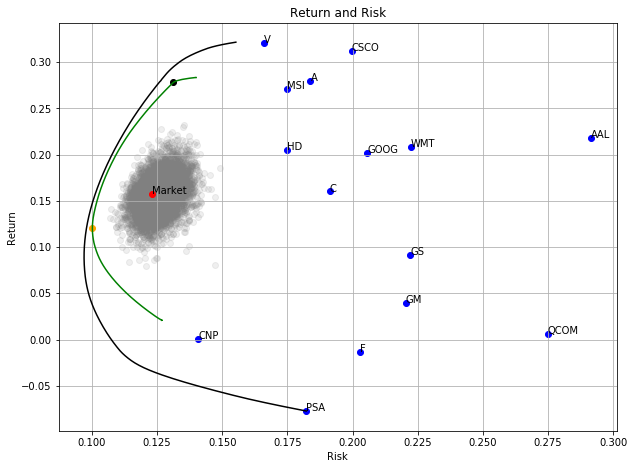

In [68]:
# Assests and Market Ploting
# ---------------------------

fig, ax = plt.subplots(figsize=(10, 7.5))

ax.scatter(x=risk_all, y=return_all, alpha=0.12, color='grey')
ax.scatter(x=returns_daily_stdev, y=returns_daily_avg, alpha=1, color='blue')
ax.scatter(x=market_risk, y=market_return, alpha=1, color='red')
ax.plot(ef_ul_risk, ef_ul_return, '-', color='black')
ax.plot(ef_risk, ef_return, '-', color='green')
ax.scatter(x=minimun_risk_risk, y=minimum_risk_return, alpha=1, color='orange')
ax.scatter(x=maximum_sharpe_risk, y=maximum_sharpe_return, alpha=1, color='black')
ax.set(title='Return and Risk', xlabel='Risk', ylabel='Return')

for i, symbol in enumerate(tickers_retrived):
    ax.annotate(symbol, (returns_daily_stdev[i], returns_daily_avg[i]))
ax.annotate('Market', (market_risk, market_return))
plt.grid()
plt.show()